# PUC Rio | MVP | Engenharia de Dados

Aluno: Joel Carneiro Dutra


## **Definição do Problema:**

Uma empresa que possui várias franquias de lojas, precisa estabelecer um fluxo de arquitetura eficiente para gerenciar o histórico de vendas de suas unidades de maneira integrada e escalável. O objetivo é estabelecer um fluxo de dados consistente e automatizado que garanta a qualidade e a acessibilidade das informações, promovendo uma gestão mais estratégica e eficiente das operações das franquias.
Isso inclui a identificação clara dos pontos de integração entre sistemas, a definição de padrões de dados e a implementação de processos que garantam a confiabilidade e a segurança das informações ao longo de todo o ciclo de vida dos dados.

## **Descrição**

Nessa etapa será apresentado a arquitetura utilizada para mapeamento dos dados.

O fluxo será construído por meio da plataforma Databricks para mapeamento da arquitetura, conforme imagem abaixo:

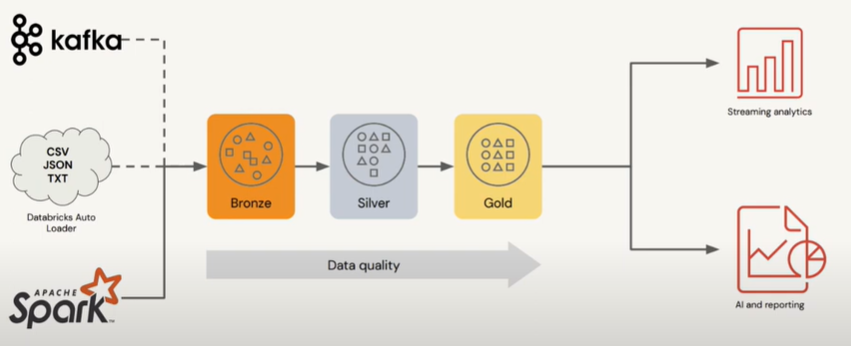

*Imagem do próprio site da Databricks*



### **Passo 1: Coleta de Dados**

Nessa etapa será apresentado o processo de inserção do dado de origem no Databricks.

A estrutura utilizada para retornar o arquivo de origem foi definido conforme imagem abaixo:

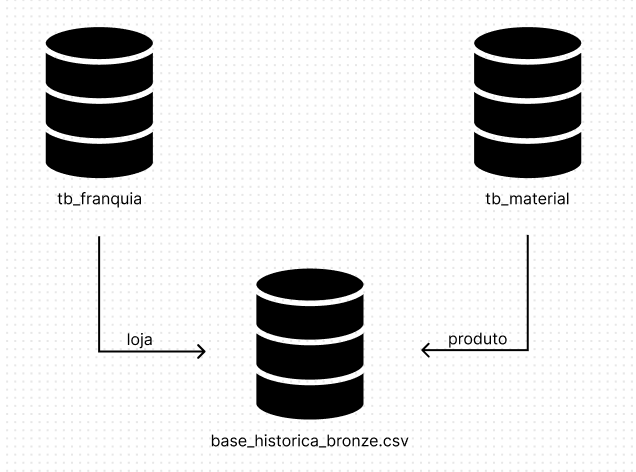

Esta etapa foi realizada por meio de uma extração no Google BigQuery, contendo os seguintes campos no arquivo de extensão CSV:

- **dt_venda** - Data em que a venda foi realizada
- **loja** - Código das franquias que realizaram as vendas
- **uf** - UF das franquias (contendo Rio de Janeiro e São Paulo)
- **produto** - Descrição do produto vendido (Produto X, Y e Z)
- **canal_venda** - Canal onde ocorreu a venda (Loja ou Site)
- **tipo_venda** - Tipo de venda (Promoção ou Regular)
- **vlr_venda** - Valor total da venda
- **qt_venda** - Quantidade de itens vendidos

Atributos:
- **qt_dias_com_estoque** - Quantidade de dias em que a loja tinha estoque
- **qt_dias_sem_estoque** - Quantidade de dias em que a loja não tinha estoque
- **qt_dias_com_estoque_aberta** - Quantidade de dias em que a loja tinha estoque e estava aberta para venda
- **qt_dias_sem_estoque_aberta** - Quantidade de dias em que a loja não tinha estoque e estava aberta para venda
- **qt_dias_loja_fechada** - Quantidade de dias em que a loja esteve fechada
- **estoque_loja** - Quantidade de estoque da loja
- **habilitador** - Determina se a loja deverá ser abastecida caso tenha menos que 5 itens em seu estoque (variável 1 ou 0)


**Observação:** Por se tratar de dados da empresa onde trabalho, foi necessário alterar os nomes dos campos para proteção dos dados.

**1a Camada | Bronze | Criação do dataset a partir do arquivo de origem**

Após a extração dos dados no BigQuery, foi realizado o upload do arquivo .csv no Databricks por meio do script abaixo:

In [ ]:
# Imports necessários
import requests
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DecimalType, DateType, BinaryType
from pyspark.sql.functions import col, to_date
import urllib.request

In [ ]:
# Definir a URL do arquivo CSV no GitHub
csv_url = "https://raw.githubusercontent.com/joel-c-dutra/mvp-ed/main/base_historica.csv"

# Caminho onde o arquivo será salvo no dbfs (Databricks File System)
dbfs_path = "/tmp/base_historica.csv"

# Baixar o arquivo CSV diretamente para o dbfs
dbutils.fs.mkdirs("/tmp")
dbutils.fs.put(dbfs_path, requests.get(csv_url).text, True)

O script acima gerou o seguinte resultado:

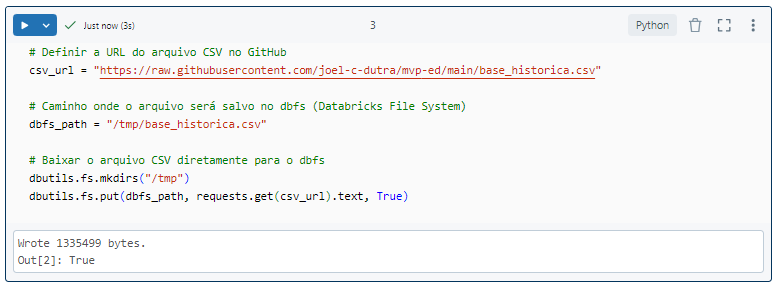

Após o upload do arquivo, foi criada a tabela base_historica_bronze, mantendo o schema dos campos.

In [ ]:
# Definir o schema com todos os campos como string
schema_bronze = "dt_venda STRING, loja STRING, uf STRING, produto STRING, canal_venda STRING, tipo_venda STRING, "\
                "vlr_venda STRING, qt_venda STRING, qt_dias_com_estoque STRING, qt_dias_sem_estoque STRING, "\
                "qt_dias_com_estoque_aberta STRING, qt_dias_sem_estoque_aberta STRING, qt_dias_loja_fechada STRING, "\
                "estoque_loja STRING, habilitador STRING"

# Ler o arquivo CSV como DataFrame, tratando todos os campos como string
df_bronze = spark.read.format("csv") \
    .option("header", "true") \
    .option("inferSchema", "false") \
    .option("delimiter", ",") \
    .schema(schema_bronze) \
    .load(dbfs_path)

# Salvar como tabela no Catálogo do Databricks
df_bronze.write.mode("overwrite").saveAsTable("base_historica_bronze")

print("Tabela 'base_historica_bronze' criada com sucesso no Catálogo do Databricks!")

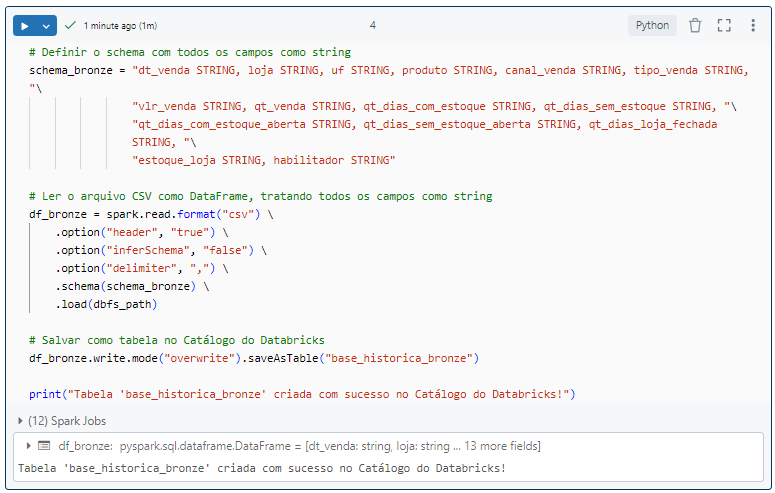

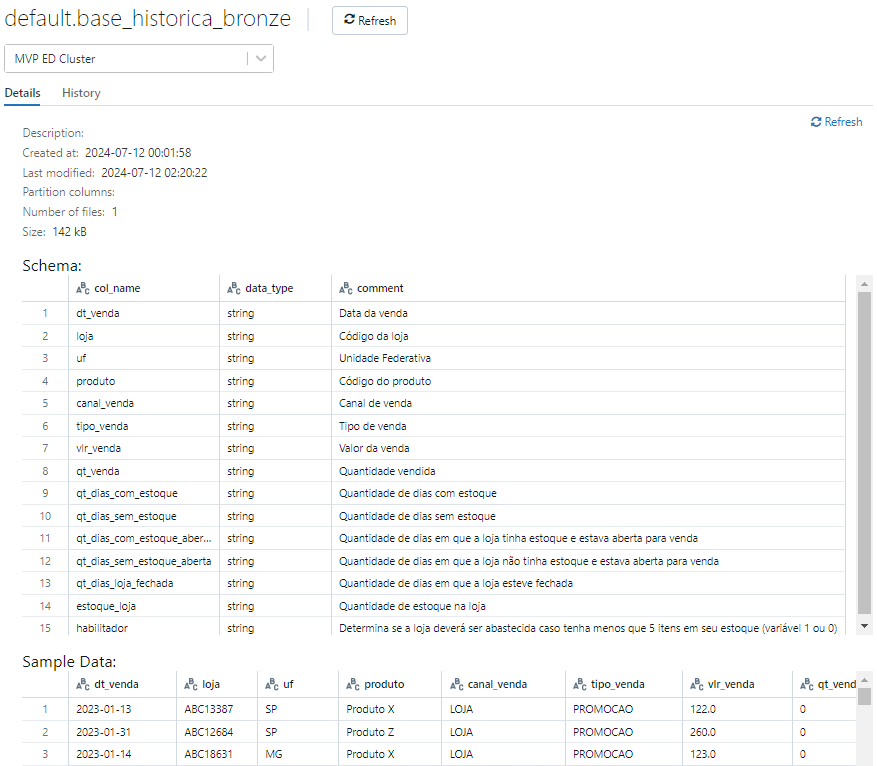

**Dataquality:** A estrutura da tabela foi analisada para identificar possíveis inconsistências nos dados, como por exemplo campos nulos ou registros repetidos (duplicidade). Para essa tabela não foram encontrados dados nulos e/ou duplicados.

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum

# Inicialize a sessão Spark
spark = SparkSession.builder \
    .appName("Dataquality Tabela Bronze - Campos nulos") \
    .getOrCreate()

# Caminho para a tabela Delta Lake
path = "dbfs:/user/hive/warehouse/base_historica_bronze"

# Leia os dados a partir do caminho de arquivo Delta Lake
df = spark.read.format("delta").load(path)

# Verifique se há campos em branco (valores nulos)
null_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])

# Mostre as contagens de valores nulos
null_counts.show()

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count

# Inicialize a sessão Spark
spark = SparkSession.builder \
    .appName("Dataquality Tabela Bronze - Campos duplicados") \
    .getOrCreate()

# Caminho para a tabela Delta Lake
path = "dbfs:/user/hive/warehouse/base_historica_bronze"

# Leia os dados a partir do caminho de arquivo Delta Lake
df = spark.read.format("delta").load(path)

# Verifique duplicatas com base em todas as colunas
df_duplicates = df.groupBy(df.columns).count().filter("count > 1")

# Mostre as duplicatas (se houver)
df_duplicates.show()

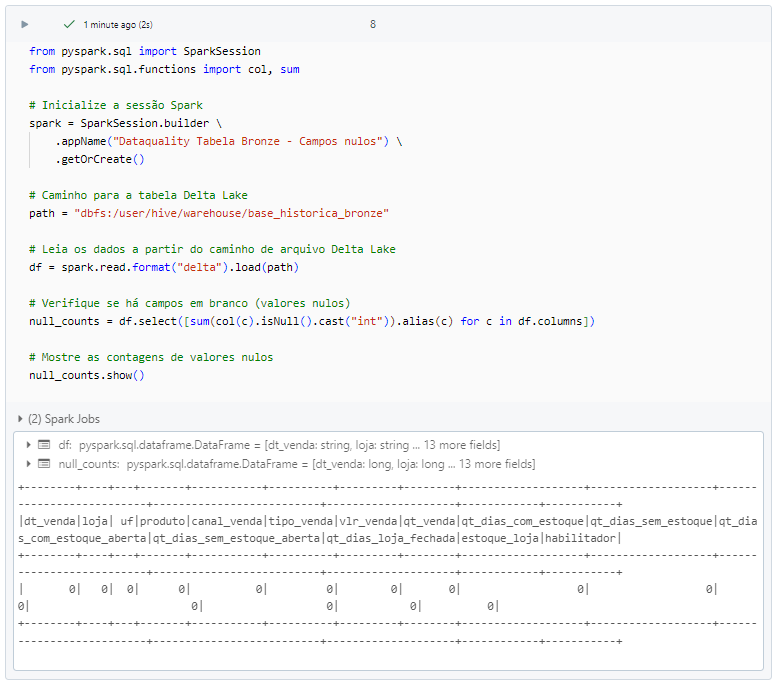

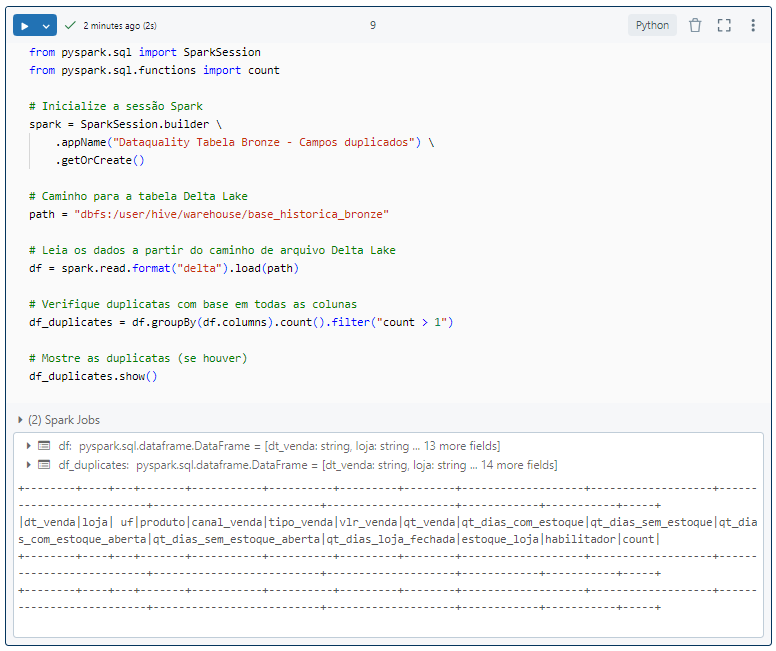

### **Passo 2: Modelagem**

Nessa etapa será criada a segunda tabela com o schema definido.

**2a Camada | Silver | Criação do dataset com o schema definido a partir do dataset inicial**

A tabela base_historica_silver foi criada a partir da base_historica_bronze, porém essa passa a ter seu schema definido.

In [ ]:
%sql

-- Remover a tabela se já existir
DROP TABLE IF EXISTS base_historica_silver;

-- Definir o novo schema
CREATE TABLE base_historica_silver (
    dt_venda DATE,
    loja STRING,
    uf STRING,
    produto STRING,
    canal_venda STRING,
    tipo_venda STRING,
    vlr_venda FLOAT,
    qt_venda INT,
    qt_dias_com_estoque INT,
    qt_dias_sem_estoque INT,
    qt_dias_com_estoque_aberta INT,
    qt_dias_sem_estoque_aberta INT,
    qt_dias_loja_fechada INT,
    estoque_loja INT,
    habilitador BOOLEAN
)
USING DELTA;

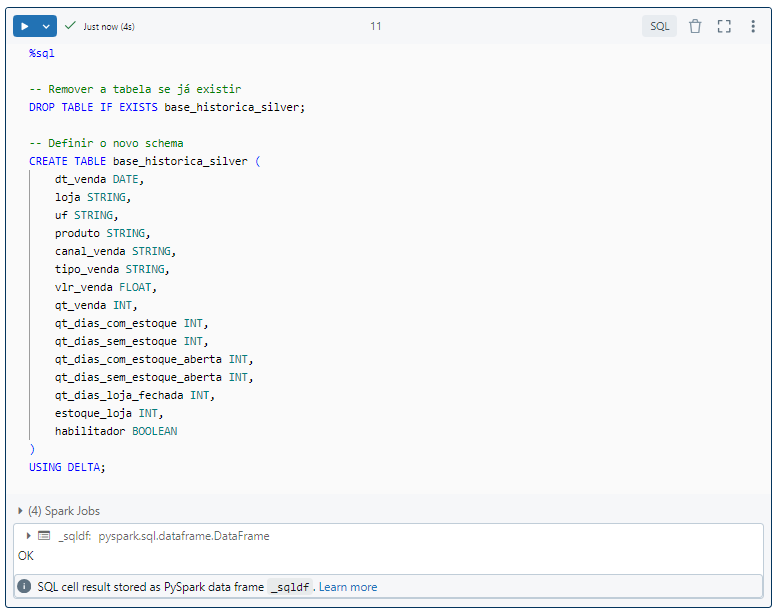

Criada a tabela, os dados são inseridos conforme código e imagem abaixo...

In [ ]:
%sql
-- Inserir dados na nova tabela com o novo schema

INSERT INTO base_historica_silver
SELECT
    TO_DATE(dt_venda, 'yyyy-MM-dd') AS dt_venda,
    loja,
    uf,
    produto,
    canal_venda,
    tipo_venda,
    ROUND(CAST(vlr_venda AS FLOAT), 3) AS vlr_venda,
    CAST(qt_venda AS INT) AS qt_venda,
    CAST(qt_dias_com_estoque AS INT) AS qt_dias_com_estoque,
    CAST(qt_dias_sem_estoque AS INT) AS qt_dias_sem_estoque,
    CAST(qt_dias_com_estoque_aberta AS INT) AS qt_dias_com_estoque_aberta,
    CAST(qt_dias_sem_estoque_aberta AS INT) AS qt_dias_sem_estoque_aberta,
    CAST(qt_dias_loja_fechada AS INT) AS qt_dias_loja_fechada,
    CAST(estoque_loja AS INT) AS estoque_loja,
    habilitador
FROM base_historica_bronze;

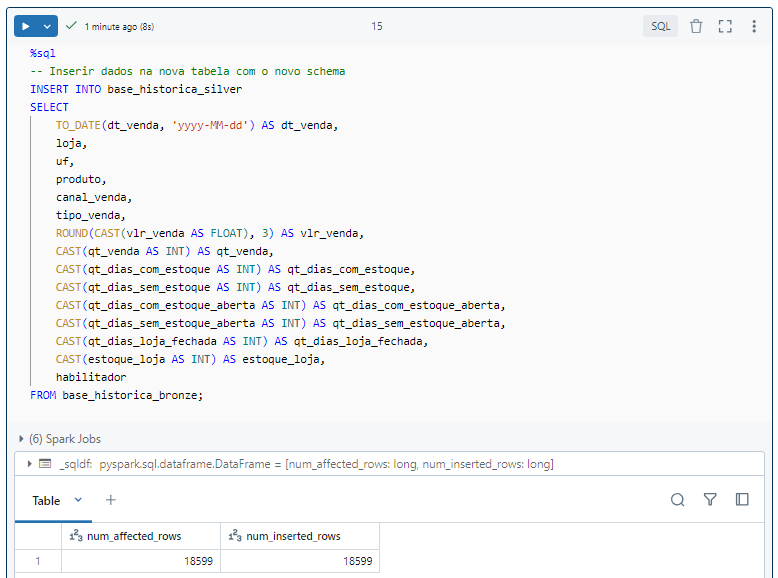

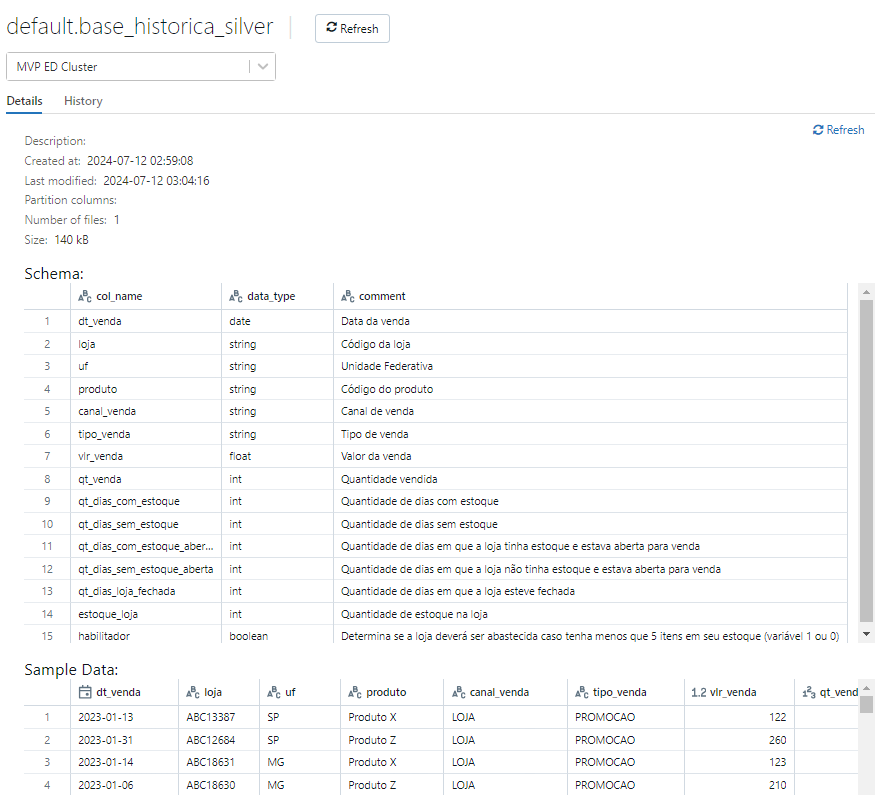

**Dataquality:** Essa tabela também foi analisada para identificar possíveis inconsistências nos dados, como por exemplo campos nulos ou registros repetidos (duplicidade).

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum

# Inicialize a sessão Spark
spark = SparkSession.builder \
    .appName("Dataquality Tabela Silver - Campos nulos") \
    .getOrCreate()

# Caminho para a tabela Delta Lake
path = "dbfs:/user/hive/warehouse/base_historica_silver"

# Leia os dados a partir do caminho de arquivo Delta Lake
df = spark.read.format("delta").load(path)

# Verifique se há campos em branco (valores nulos)
null_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])

# Mostre as contagens de valores nulos
null_counts.show()

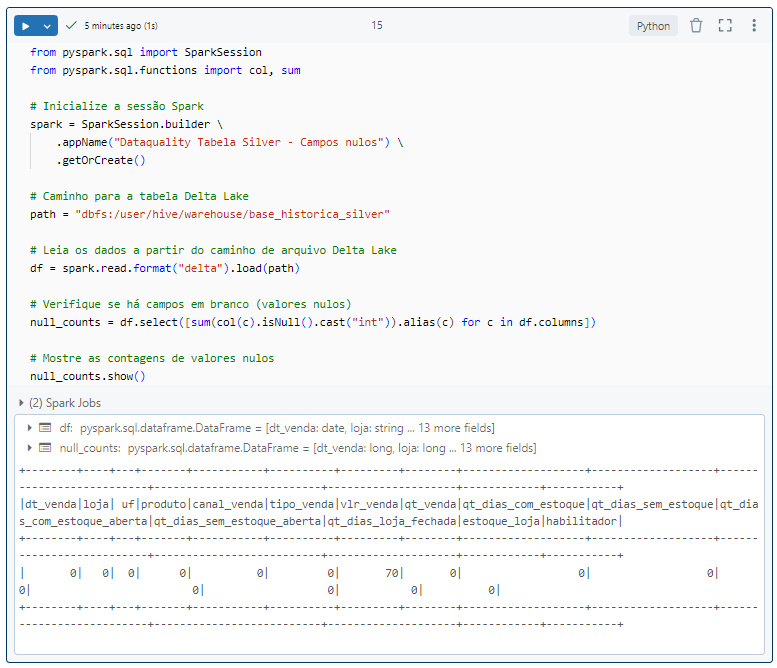

Conforme apresentado na imagem acima, a tabela base_historica_silver possui 70 registros nulos no campo vlr_venda. Dessa forma, foi necessário efetuar a limpeza da tabela.

In [ ]:
from pyspark.sql import SparkSession

# Inicialize a sessão Spark
spark = SparkSession.builder \
    .appName("Remove Null Records") \
    .getOrCreate()

# Caminho para a tabela Delta Lake
path = "dbfs:/user/hive/warehouse/base_historica_silver"

# Leia os dados a partir do caminho de arquivo Delta Lake
df = spark.read.format("delta").load(path)

# Filtre os registros com valores nulos no campo vlr_venda
df_cleaned = df.filter(df.vlr_venda.isNotNull())

# Salve o DataFrame resultante de volta no Delta Lake, sobrescrevendo a tabela original
df_cleaned.write.format("delta").mode("overwrite").save(path)

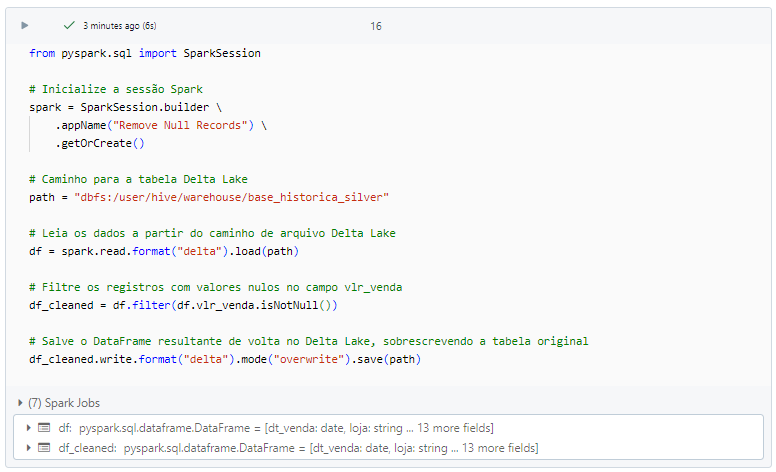

Após rodar o comando acima, a tabela teve seus registros nulos removidos, conforme imagem abaixo:
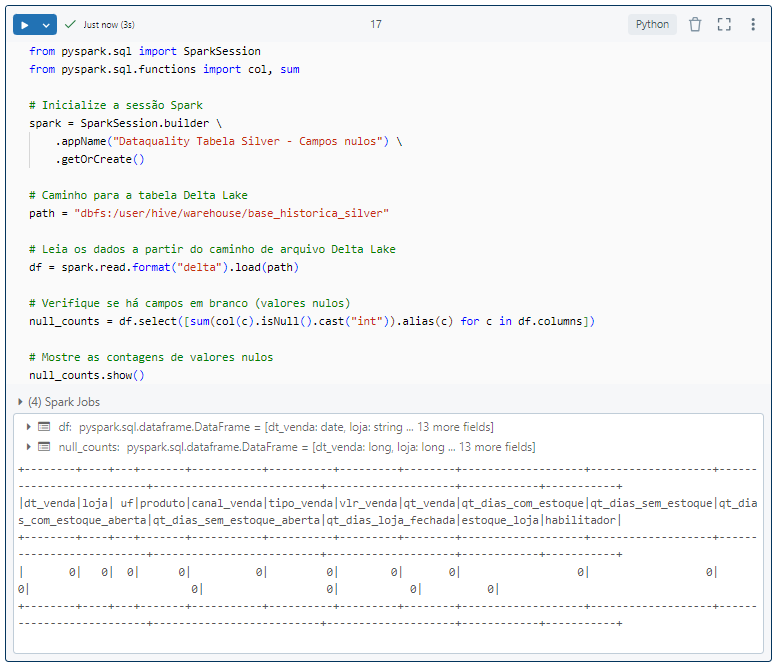

A mesma também não apresentou registros duplicados.

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count

# Inicialize a sessão Spark
spark = SparkSession.builder \
    .appName("Dataquality Tabela Silver - Campos duplicados") \
    .getOrCreate()

# Caminho para a tabela Delta Lake
path = "dbfs:/user/hive/warehouse/base_historica_silver"

# Leia os dados a partir do caminho de arquivo Delta Lake
df = spark.read.format("delta").load(path)

# Verifique duplicatas com base em todas as colunas
df_duplicates = df.groupBy(df.columns).count().filter("count > 1")

# Mostre as duplicatas (se houver)
df_duplicates.show()

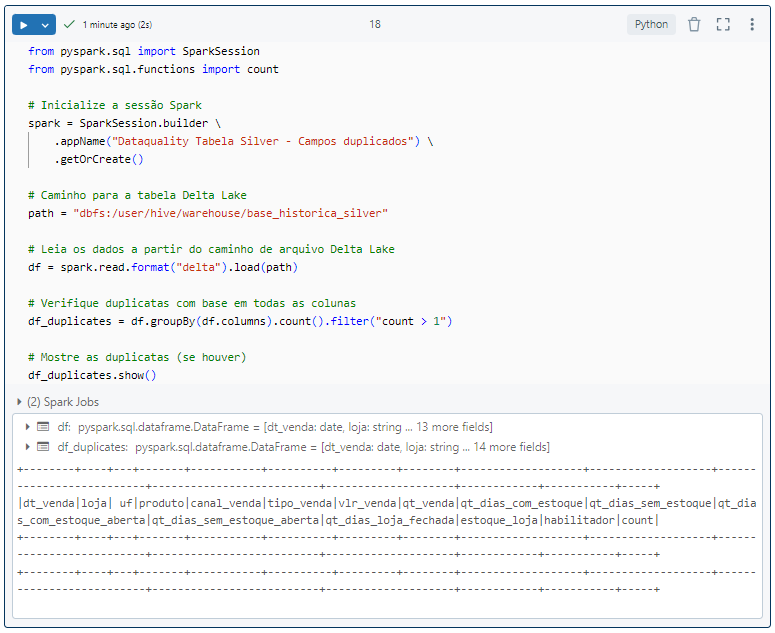

### **Passo 3: Carga**

Nessa etapa será criada a terceira tabela para análise dos dados.

**3a Camada | Gold | Criação do dataset com o schema definido e suas agregações**

A tabela base_historica_gold foi criada a partir da base_historica_silver, porém além do seu schema definido também possui agregações em sua composição, como por exemplo: agregação por mês, soma de vendas e soma de itens vendidos.

In [ ]:
%sql
-- Criar a tabela base_historica_gold com dados agregados por mês

CREATE OR REPLACE TABLE base_historica_gold
USING DELTA
AS
SELECT
    CAST(DATE_TRUNC('month', dt_venda) AS DATE) AS dt_anomes,
    uf,
    loja,
    produto,
    canal_venda,
    tipo_venda,
    ROUND(SUM(vlr_venda), 2) AS total_vendas,
    SUM(qt_venda) AS total_itens_vendidos
FROM base_historica_silver
GROUP BY CAST(DATE_TRUNC('month', dt_venda) AS DATE), uf, loja, produto, canal_venda, tipo_venda
ORDER BY CAST(DATE_TRUNC('month', dt_venda) AS DATE), uf, loja, produto, canal_venda, tipo_venda;

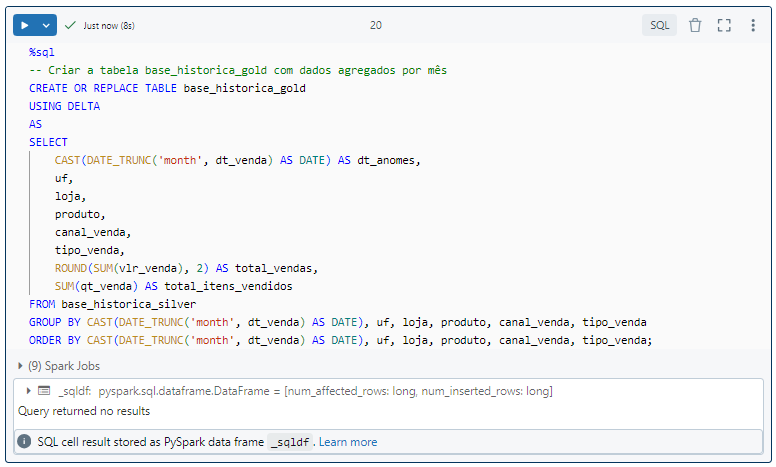

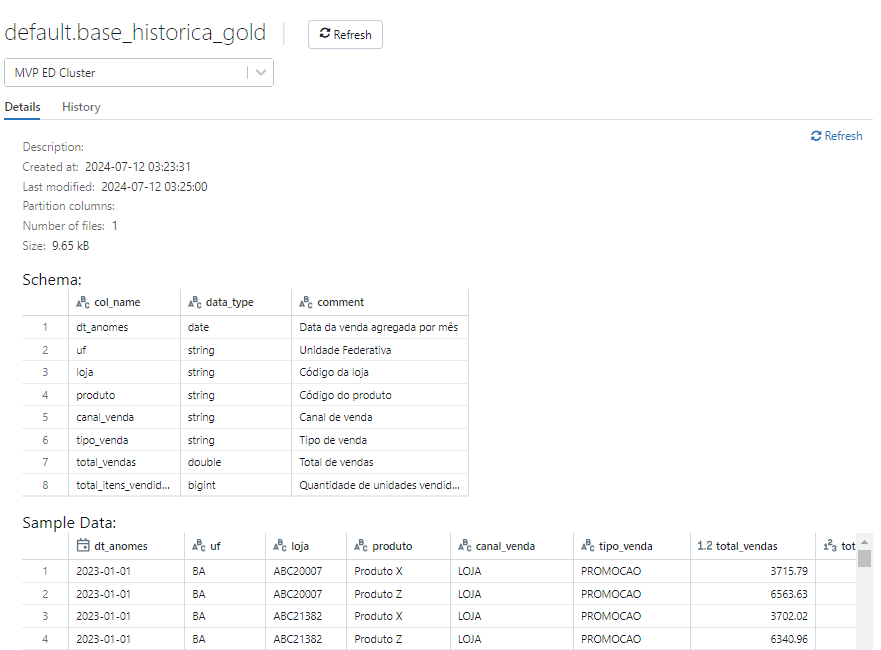

**Dataquality:** Assim como as tabelas anteriores, essa tabela também foi analisada para identificar possíveis inconsistências nos dados, como por exemplo campos nulos ou registros duplicados. Para essa tabela não foram encontrados dados nulos e/ou duplicados.

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum

# Inicialize a sessão Spark
spark = SparkSession.builder \
    .appName("Dataquality Tabela Gold - Campos nulos") \
    .getOrCreate()

# Caminho para a tabela Delta Lake
path = "dbfs:/user/hive/warehouse/base_historica_gold"

# Leia os dados a partir do caminho de arquivo Delta Lake
df = spark.read.format("delta").load(path)

# Verifique se há campos em branco (valores nulos)
null_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])

# Mostre as contagens de valores nulos
null_counts.show()

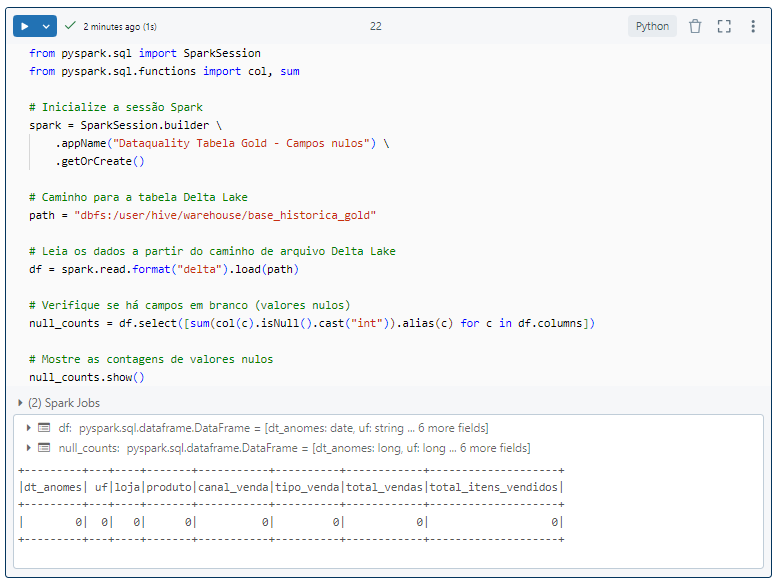

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count

# Inicialize a sessão Spark
spark = SparkSession.builder \
    .appName("Dataquality Tabela Gold - Campos duplicados") \
    .getOrCreate()

# Caminho para a tabela Delta Lake
path = "dbfs:/user/hive/warehouse/base_historica_gold"

# Leia os dados a partir do caminho de arquivo Delta Lake
df = spark.read.format("delta").load(path)

# Verifique duplicatas com base em todas as colunas
df_duplicates = df.groupBy(df.columns).count().filter("count > 1")

# Mostre as duplicatas (se houver)
df_duplicates.show()

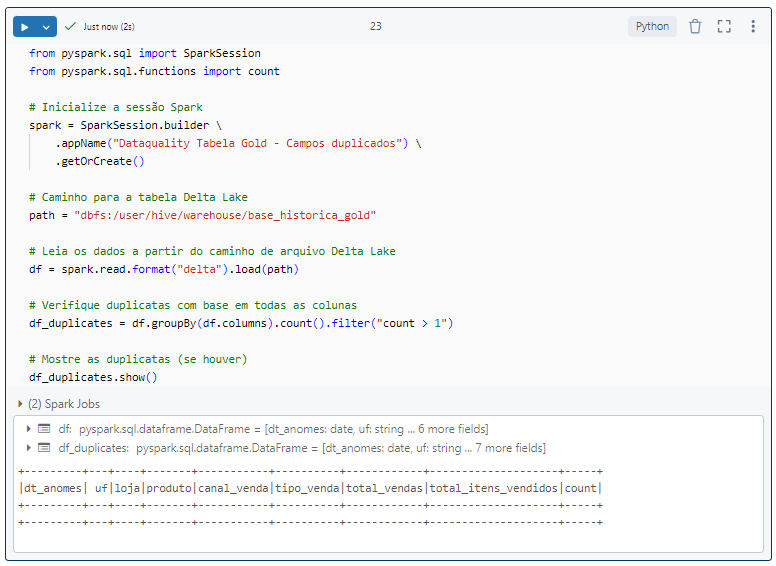

### **Passo 4: Análise**

Nessa etapa os dados são disponibilizados para consulta e análise dos dados.

A patir dessa etapa, a tabela gold é fornecida para acompanhamento da(s) área(s). Por meio de uma ferramenta de Dataviz, é possível visualizar as informações e assim tomar decisões com base nos dados obtidos.

In [ ]:
%sql
SELECT * FROM base_historica_gold

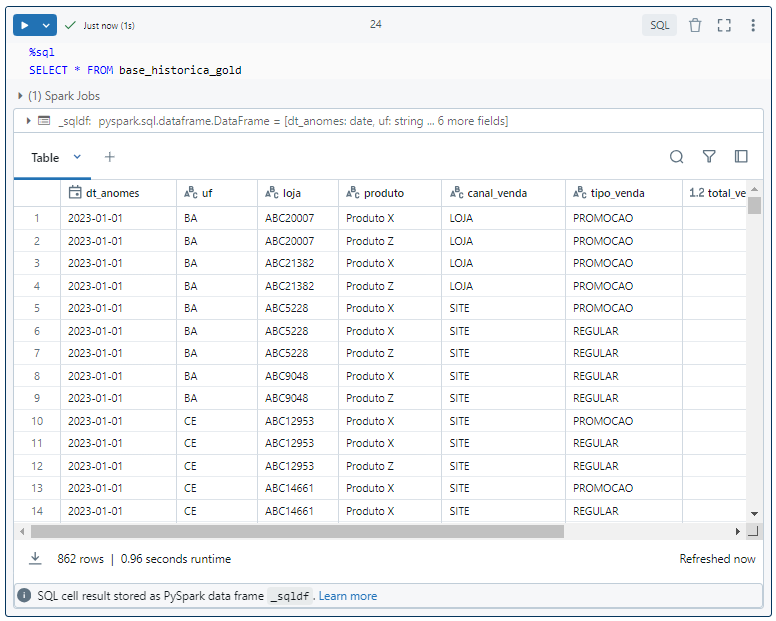

A ferramenta utilizada para análise dos dados foi o Tableau. Por meio dela, foi possível mapear indicadores e responder algumas perguntas baseadas nos dados.

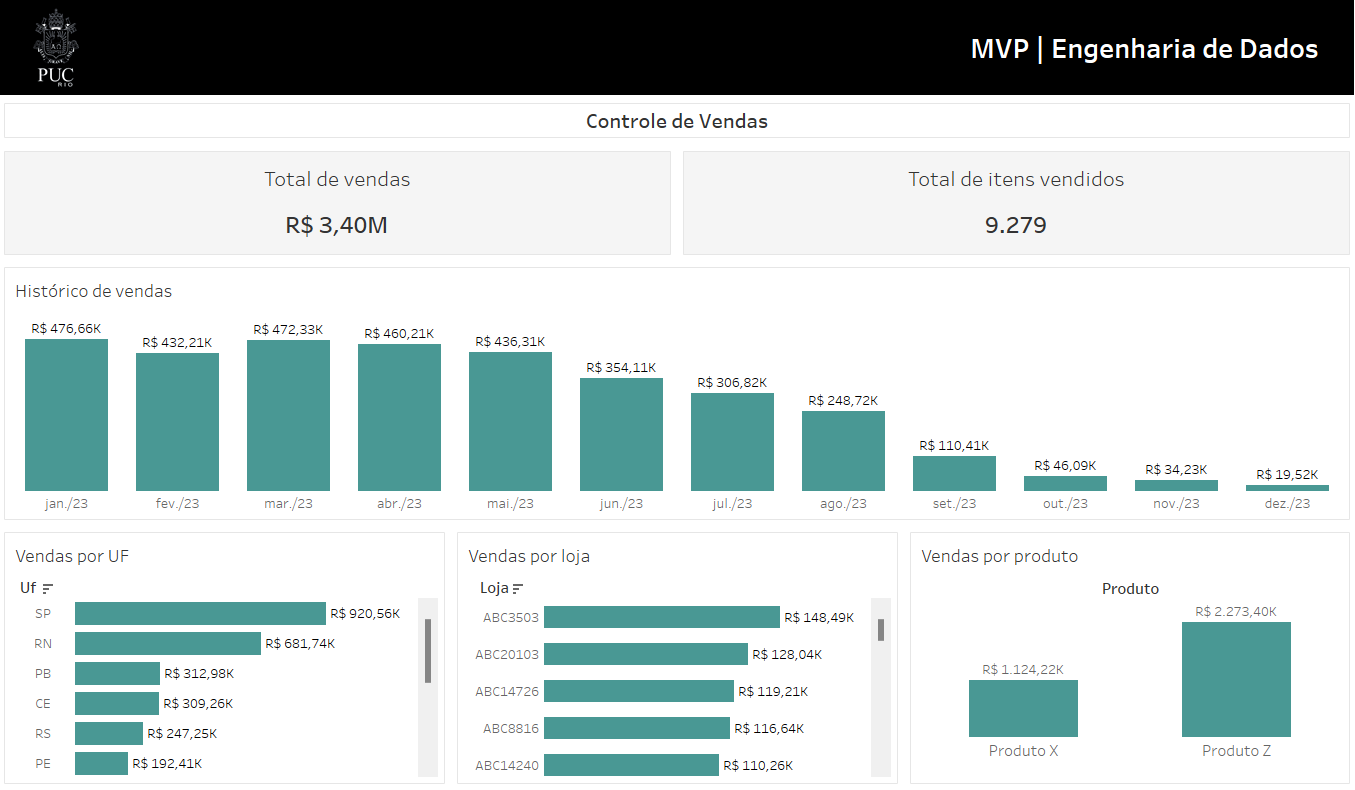

**Perguntas respondidas:**

Qual o mês em que houve o maior resultado em vendas?

*   *Jan/23 com R$476,66K*


Qual o Estado que mais vendeu durante o ano de 2023?

*   *São Paulo com R$920,56K*


Qual a loja que mais vendeu produtos em 2023?

*   *A loja ABC3503 com R$148,49K*


Qual foi o produto mais vendido?

*   *O produto Z vendeu um total de R$2.273,40K*


### **Autoavaliação**

Ao replicar o dataset da primeira para a segunda camada definindo seu “schema”, não foi possível efetuar a ação por meio do código python, pois retornava um erro informando que o campo “dt_venda” não poderia ser alterado por ter o mesmo nome entre ambas as tabelas e o tipo de schema diferente. Dessa forma, foi necessário seguir com comandos SQL para dar seguimento no processo.


---



Ao criar o dataset da segunda camada, ocorria um erro no Databricks informando que já existia uma tabela com esse nome criada no Catálogo e também não era uma tabela Delta. No entanto essa tabela não aparecia na árvore do Catálogo e foi então necessário rodar o código do Databricks para remoção da mesma do sistema:

In [ ]:
# Listar o conteúdo do diretório no DBFS
dbutils.fs.ls("dbfs:/user/hive/warehouse/")
# Remover o diretório e seu conteúdo
dbutils.fs.rm("dbfs:/user/hive/warehouse/base_historica_silver", recurse=True)

Ao tentar inserir os comentários nos datasets, foi necessário fazer linha a linha para a inclusão dos mesmos, sendo um script para cada dataset.

**Considerações finais:** Apesar da plataforma Databricks Community ter suas limitações por oferecer uma permissão para teste/estudo, permitiu ter uma ampla visão das possibilidades e o entendimento da arquitetura que hoje é aplicada em muitas empresas. Vejo que muitas empresas também estão aderindo a essa ferramenta, tornando o MVP ainda mais benéfico durante a sprint.